# <span style="color:blue"> <center>Case Geofusion - Predição de Faturamento</center></span>
## <center>1. Estimar o faturamento que uma loja teria em cada um dos bairros</center>
<center>Solução proposta por Lucas Victor Silva Pereira</center>

O objetivo é estimar o faturamento que a empresa terá caso comece a operar nos bairros da cidade de São Paulo. O faturamento nos bairros da cidade do Rio de Janeiro onde a empresa já está consolidada estão à disposição e inclusive já foram tratados.

Durante a análise dos dados foi possível constatar que os dados correspondentes a maioria das variáveis da base de dados <font style="font-family: monaco">dfFoodBRJ</font>, correspondem à uma *<font style="font-family: monaco">distribuição normal</font>*. Devido a isso, o método de regressão escolhido foi a **regressão linear**: $$Y \approx \beta_0 + \beta_1 x_{1} + ... + \beta_{d} X_{d}$$
$$Y = \beta_0 + \beta_1 x_{1} + ... + \beta_{d} X_{d} + \epsilon$$

In [36]:
#Required Libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler#, MinMaxScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso#, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
#Read and process the database
url = 'dataset/DadosDeliciousFood.csv'

dfFoodB = pd.read_csv(url, encoding='utf-8')
dfFoodB = dfFoodB.drop_duplicates()
if (dfFoodB.duplicated('codigo').sum() > 0):
    print("ALERT: DATA CONFLICT. Check possible solutions with data engineers.")
dfFoodB = dfFoodB.replace('-', np.nan)
dfFoodB = dfFoodB.replace('?', np.nan)

mask = ((dfFoodB['popAte9'] == 0) & (dfFoodB['popDe10a14'] == 0) & (dfFoodB['popDe15a19'] == 0) & \
        (dfFoodB['popDe20a24'] == 0) & (dfFoodB['popDe25a34'] == 0) & (dfFoodB['popDe35a49'] == 0) & \
        (dfFoodB['popDe50a59'] == 0) & (dfFoodB['popMaisDe60'] == 0)) |\
       ((dfFoodB['domiciliosA1'] == 0) & (dfFoodB['domiciliosA2'] == 0) & (dfFoodB['domiciliosB1'] == 0) & \
        (dfFoodB['domiciliosB2'] == 0) & (dfFoodB['domiciliosC1'] == 0) & (dfFoodB['domiciliosC2'] == 0) & \
        (dfFoodB['domiciliosD'] == 0) & (dfFoodB['domiciliosE'] == 0)) |\
       (dfFoodB['população'] != (dfFoodB['popAte9'] + dfFoodB['popDe10a14'] + dfFoodB['popDe15a19'] + \
                                 dfFoodB['popDe20a24'] + dfFoodB['popDe25a34'] + dfFoodB['popDe35a49'] + \
                                 dfFoodB['popDe50a59'] + dfFoodB['popMaisDe60'])) |\
       ((dfFoodB['rendaMedia'] == 0) & (dfFoodB['faturamento'] == 0))
dfFoodB = dfFoodB.loc[~mask]

dfFoodBRJ = dfFoodB.loc[dfFoodB['estado'] == "RJ"]

dfFoodBRJ = dfFoodBRJ.dropna(axis='rows') #remove rows NaN/null

dfFoodBRJ = dfFoodBRJ.drop(['codigo','nome','cidade','estado','população'], axis=1)

dfFoodBRJP = dfFoodBRJ['potencial']
dfFoodBRJ = dfFoodBRJ.drop('potencial', axis=1)

dfFoodBRJ = dfFoodBRJ.astype('float')

dfFoodBRJ.iloc[:,0:16] = dfFoodBRJ.iloc[:,0:16] / 100
dfFoodBRJ['rendaMedia'] = np.log(dfFoodBRJ['rendaMedia'])
dfFoodBRJ['faturamento'] = dfFoodBRJ['faturamento'] / 10000

mask = (dfFoodBRJ['rendaMedia'] >= 11)
dfFoodBRJ = dfFoodBRJ.loc[~mask]

In [38]:
x_train, x_test, y_train, y_test = train_test_split(dfFoodBRJ.drop('faturamento', axis=1), dfFoodBRJ['faturamento'],\
                                                    test_size = 0.2, random_state = 41)
print(x_train.shape)
print(x_test.shape)
print(x_train.shape)
print(x_test.shape)

(122, 17)
(31, 17)
(122, 17)
(31, 17)


In [39]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [40]:
pca = PCA(n_components=4)

x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

print("Variância explicada:", pca.explained_variance_ratio_)
print("Variância Explicada pelos 4 Primeiros Componentes:", pca.explained_variance_ratio_.sum())

Variância explicada: [0.70975924 0.19783229 0.04058356 0.02399424]
Variância Explicada pelos 4 Primeiros Componentes: 0.9721693290248964


In [41]:
lm = LinearRegression()
scores = cross_val_score(lm, x_train, y_train, scoring='r2', cv=KFold(n_splits=5, random_state=None, shuffle=False))

print("scores =", scores)
print("Accuracy: %.2f%%" % (scores.mean()*100.0)) 
#scores

scores = [0.92622806 0.86583151 0.95806817 0.91955299 0.96520106]
Accuracy: 92.70%


In [99]:
X = dfFoodBRJ.drop('faturamento', axis=1)
X_numpy = X.to_numpy()
y = dfFoodBRJ['faturamento'].to_numpy()

cv_outer = KFold(4, shuffle=True)
cont = 1
lm = LinearRegression()
for train_i, test_i in cv_outer.split(X_numpy):
    print(f'Iteration: {cont}')
    cont += 1
    
    scaler = StandardScaler().fit(X_numpy[train_i])
    x_train = scaler.fit_transform(X_numpy[train_i])
    x_test = scaler.fit_transform(X_numpy[test_i])
    
    #pca = PCA(n_components=4).fit_transform(x_train)
    #x_train = pca.transform(x_train)
    #x_test = pca.transform(x_test)
    
    scores = cross_val_score(lm, x_train, y[train_i], scoring='r2', cv=KFold(n_splits=5, random_state=102,\
                                                                             shuffle=True))
    
    print("scores =", scores)
    print("Accuracy mean: %.2f%%" % (scores.mean()*100.0))

Iteration: 1
scores = [-10.36679186   0.97162963   0.94354383   0.68565443   0.91346647]
Accuracy mean: -137.05%
Iteration: 2
scores = [0.8708694  0.82481385 0.42312754 0.80056695 0.94091053]
Accuracy mean: 77.21%
Iteration: 3
scores = [ 0.9479661   0.89481864 -2.44913621  0.92730533  0.93207549]
Accuracy mean: 25.06%
Iteration: 4
scores = [0.94675512 0.69947894 0.90940659 0.83823003 0.93692655]
Accuracy mean: 86.62%


In [85]:
lm.fit(x_train, y_train)

y_pred = lm.predict(x_test)

ValueError: Found input variables with inconsistent numbers of samples: [115, 122]

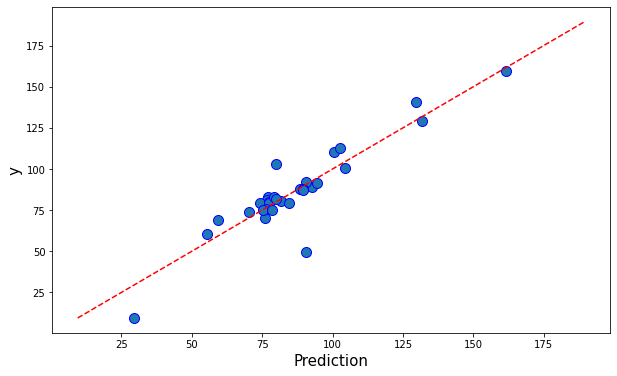

In [43]:
fig = plt.figure(figsize=(10,6))
l = plt.plot(y_pred, y_test, 'bo')
plt.setp(l, markersize=10)
plt.setp(l, markerfacecolor='C0')

plt.ylabel("y", fontsize=15)
plt.xlabel("Prediction", fontsize=15)

# mostra os valores preditos e originais
xl = np.arange(min(y_test), 1.2*max(y_test),(max(y_test)-min(y_test))/10)
yl = xl
plt.plot(xl, yl, 'r--')

plt.show(True)

In [44]:
R2 = r2_score(y_test, y_pred)
print('R2:', round(R2, 3))
def adjusted_r2(y_test, y_pred,X_train):
    adj_r2 = (1 - ((1 - r2_score(y_test, y_pred)) * (len(y_test) - 1)) / (len(y_test) - X_train.shape[1] - 1))
    
    return adj_r2

print("adjusted_r2:", round(adjusted_r2(y_test, y_pred, x_train), 3))

RMSE = mean_squared_error(y_test,y_pred) #RMSE = mean_squared_error(y_test,y_pred,squared=False)
print("RMSE:", round(RMSE, 3))

R2: 0.843
adjusted_r2: 0.819
RMSE: 107.504


### **<center>Regressão Ridge</center>**

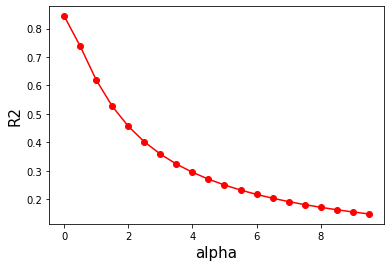

In [45]:
vR2 = []
valpha = []
r2Max = -1.0
alphaMax = -1.0
# variamos os valaores de alpha
for alpha in np.arange(0,10,0.5):
    ridge2 = Ridge(alpha = alpha, normalize = True)
    ridge2.fit(x_train, y_train)             # Fit a ridge regression on the training data
    y_pred = ridge2.predict(x_test)           # Use this model to predict the test data
    r2 = r2_score(y_test, y_pred)
    vR2.append(r2)
    valpha.append(alpha)
    if r2 > r2Max:
        r2Max = r2
        alphaMax = alpha
plt.plot(valpha, vR2, '-ro')
plt.xlabel("alpha", fontsize=15)
plt.ylabel("R2", fontsize=15)
plt.show(True)

### **<center>Regressão Lasso</center>**

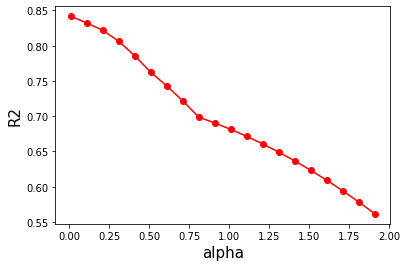

Alpha-best: 0.01


In [46]:
vR2 = []
valpha = []
r2Max = -1.0
alphaMax = -1.0
for alpha in np.arange(0.01,2,0.1):
    lasso = Lasso(alpha = alpha, normalize = True)
    lasso.fit(x_train, y_train)             # Fit a ridge regression on the training data
    y_pred = lasso.predict(x_test)           # Use this model to predict the test data
    r2 = r2_score(y_test, y_pred)
    vR2.append(r2)
    valpha.append(alpha)
    if r2 > r2Max:
        r2Max = r2
        alphaMax = alpha
plt.plot(valpha, vR2, '-ro')
plt.xlabel("alpha", fontsize=15)
plt.ylabel("R2", fontsize=15)
plt.show(True)

print("Alpha-best:", alphaMax)

In [47]:
alpha = alphaMax
# notice that we need to normalize the attributes: normalize = True
lasso = Lasso(alpha=alpha,normalize=True, max_iter=1e5)
lasso.fit(x_train, y_train)             # Fit a ridge regression on the training data
y_pred = lasso.predict(x_test)           # Use this model to predict the test data
RSME = mean_squared_error(y_test, y_pred)         # Calculate the test MSE

print('R2:', round(R2, 2))
print("Adjusted_R2:", round(adjusted_r2(y_test, y_pred, x_train), 2))
print("RSME:", round(RSME, 2))          # Calculate the test MSE

R2: 0.84
Adjusted_R2: 0.82
RSME: 108.66


In [48]:
print('Coeficientes: C_1, C_2, C_3, C-4:', lasso.coef_)

Coeficientes: C_1, C_2, C_3, C-4: [-2.54603155 24.34209609  6.3458862  -0.47286865]


Tanto *Ridge Regression* quanto *LASSO Regression* deram os melhores resultados como $\alpha~=~0$. A reta que melhor descreve os dados é dada por: $$y = \beta_0 + \beta_1 x + \beta_2 x + \beta_3 x + \beta_4 x$$ onde, os valores de $\beta_{i}$ aparecem na célula de código acima.

Dada essa melhor reta, pode-se predizer os valores de faturamento para os bairros da cidade de São Paulo.

### **<center>Predizendo os valores de Faturamento para os bairros da cidade de São Paulo</center>**

In [49]:
dfFoodBSP = dfFoodB.loc[dfFoodB['estado'] == "SP"]

dfFoodBSP = dfFoodBSP.drop(['faturamento','potencial'], axis=1)
dfFoodBSP = dfFoodBSP.dropna(axis='rows') #remove rows NaN/null
dfFoodBSP = dfFoodBSP.drop(['codigo','nome','cidade','estado','população'], axis=1)
dfFoodBSP = dfFoodBSP.astype('float')

dfFoodBSP.iloc[:,0:16] = dfFoodBSP.iloc[:,0:16] / 100
dfFoodBSP['rendaMedia'] = np.log(dfFoodBSP['rendaMedia'])

In [50]:
scaler = StandardScaler().fit(dfFoodBSP)
dfFoodBSP = scaler.transform(dfFoodBSP)

dfFoodBSP = pca.fit_transform(dfFoodBSP)

In [51]:
y_pred_SP = lm.predict(dfFoodBSP)
#print(y_pred_SP)